### Goal: train a neural network to classify letters written by hand.

### Steps:
1. Load data
2. Data preprocessing
3. Configure a CNN
4. Train a CNN
5. Evaluate on a test set
6. Visualize the model's predictions on test images 
7. Save the model to disk

In [ ]:
# The dataset used in this notebook is availbale at
# https://www.kaggle.com/olgabelitskaya/classification-of-handwritten-letters

from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
import sys
sys.path.append('/content/gdrive/My Drive/Letters')

In [ ]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import random
import cv2

import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import cm
%matplotlib inline

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.metrics import top_k_categorical_accuracy,categorical_accuracy

from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#check version of library
import tensorflow as tf
tf.__version__

'2.3.0'

In [ ]:
data_path='/content/gdrive/My Drive/Letters/archive.zip'
disk_folder="/content/gdrive/My Drive/Letters"
folder='/content/gdrive/My Drive/Letters/images/'

In [ ]:
#create folder and unzip
import zipfile
import os

try:
  os.mkdir(folder)
except:
  print('Folder already exists!')

In [ ]:
%%time
with zipfile.ZipFile(data_path, 'r') as zip_ref:
  zip_ref.extractall(folder)

CPU times: user 8.24 s, sys: 4.42 s, total: 12.7 s
Wall time: 5min 46s


## <font color='scarlett'> 1. Load data

Loading the dataframe containing the information about the images.


In [ ]:
data_info =  ['letters.csv', 'letters2.csv', 'letters3.csv']

In [ ]:
def import_data(data_info):

  """Creates an additional column: the path to the imag"""
  data = pd.read_csv(folder + '/' + data_info)
  data['source'] = data_info[:-4]+'/'
  return data

In [ ]:
letters = [import_data(file) for file in data_info]
data = pd.concat(letters, ignore_index=True)
data.shape

(14190, 5)

In [ ]:
# Shuffle the data
data = shuffle(data, random_state = 42)

In [ ]:
data.head(3)

,letter,label,file,background,source
5648,х,23,23_89.png,2,letters2/
8023,в,3,03_264.png,3,letters3/
8989,ё,7,07_430.png,3,letters3/


We can see that our dataset contains the following information: the letter, the encoded label, the filename, the background on the paper and the path to the file.



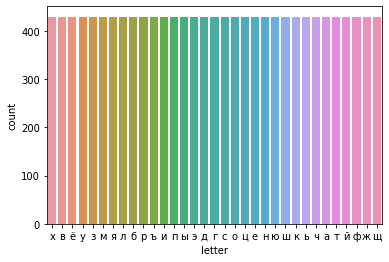

In [ ]:
# Plot the class' distribution
sns.countplot(x="letter", data=data)

The dataset is balanced.

## <font color='orange'> 2. Data preprocessing
### <font color='orange'> 2.1 Target encoding.

Since we are going to use neural networks, it would be better to use One-hot encoding rather than ordinal. One-hot encoding means that each class (letter) will be represented by a separate column. The values will be either 0 or 1 depending on whether the image contains the letter.

In [ ]:
letters = '' 
for letter in data['letter'].unique():
    letters += letter
    
targets = data['label']

In [ ]:
def ohe_letter(target):
  """Performs one-hot encoding"""
    result = np.zeros(len(letters))
    index = letters.index(target)
    result[index] = 1
    return result

In [ ]:
data['enc_letter'] = data['letter'].apply(ohe_letter)
data.head()

,letter,label,file,background,source,enc_letter
0,а,1,01_01.png,0,letters/,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,а,1,01_02.png,0,letters/,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,а,1,01_03.png,0,letters/,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,а,1,01_04.png,0,letters/,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,а,1,01_05.png,0,letters/,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### <font color='orange'> 2.2 Image preprocessing.

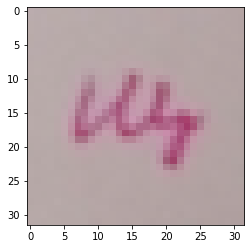

In [ ]:
# set the image size
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3) # 3 - число каналов

# let's look at one of the images
image_file_name = folder + 'letters2/27_212.png'
img = image.load_img(image_file_name, target_size=(img_width, img_height))
plt.imshow(img)

In [ ]:
# Store all png images into one numpy array
images = []

# Will be the target
encoded_targets = []

# Want to be sure that every image is consitent
for i, row in data.iterrows():
    img_name = row['file']
    numpy_image = cv2.imread(os.path.join(folder + row['source'], img_name))
    if numpy_image.shape == input_shape:
        images.append(numpy_image)
        encoded_targets.append(row['enc_letter'])
        
# Normalize the array of images
images = np.array(images)/255

In [ ]:
len(images), len(encoded_targets)

(14178, 14178)

### <font color='orange'> 2.3 Creating train and test sets

As we are dealing with the classification problem, it's important to make sure that the class distribution is consistent in both train and test sets.

In order to control this, we will use `stratify` -- the parameter of `train_test_split` function.

In [ ]:
X = np.array(images.copy())
y = np.array(encoded_targets.copy())

# Stratified train_test split on labels
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=.2, 
                                                  stratify = y, 
                                                  random_state=42)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((11342, 32, 32, 3), (2836, 32, 32, 3), (11342, 33), (2836, 33))

In [ ]:
# Create generators to train a neural net with a real-time augmentation.
datagen = ImageDataGenerator(rescale=1. / 255,
                              rotation_range=40,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              zoom_range=0.2,
                              horizontal_flip=True,
                              fill_mode='nearest')
datagen.fit(X_train)

## <font color='green'> 3. Configure a CNN

In [ ]:
# The shape of input tensors
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3)

# Number of classes to consider
num_classes = len(letters)

# Group of training samples
batch_size = 64

# Number of complete presentations of the dataset to be learned
epochs = 100

In [ ]:
# Define a custom metric
def top_3_categorical_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 25, 25, 128)       131200    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

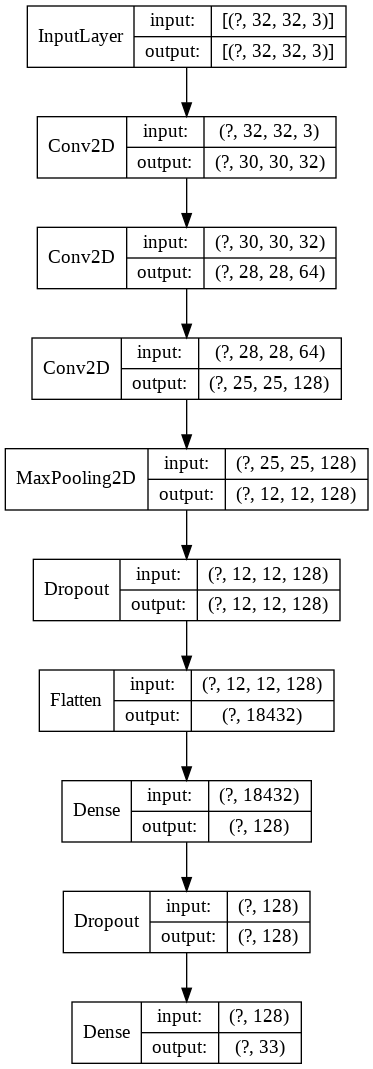

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu', input_shape = input_shape))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(Conv2D(128, (4, 4), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation = 'softmax'))

# Compile the model
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy', top_3_categorical_accuracy])
model.summary()
plot_model(model, to_file='/content/gdrive/My Drive/Letters/model_plot.png', expand_nested=True, show_shapes=True, show_layer_names=False)

In the following cell, we define the callbacks that will make our life a bit easier:

- `ReduceLROnPlateau` will automatically reduce learning rate when a metric has stopped improving
- `ModelCheckpoint` will save the best model to disk so we can re-use it later.

In [ ]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                 patience=10, 
                                 verbose=2, 
                                 factor=.75)

model_checkpoint= ModelCheckpoint(disk_folder+"/best_result_checkpoint", monitor='val_loss', save_best_only=True, verbose=0)

# stop training if a loss is not improving after 20 epochs.
early_stopping = EarlyStopping(monitor='val_loss', 
                          patience=20, 
                          verbose=2)

## <font color='blue'> 4. Train a CNN

In [ ]:
%%time


history = model.fit(X_train, y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = 1,
                    validation_data = (X_val, y_val),
                    callbacks = [model_checkpoint, lr_reduction, early_stopping])

Epoch 1/100
178/178 [==============================] - 3s 14ms/step - loss: 3.4926 - accuracy: 0.0329 - top_3_categorical_accuracy: 0.0988 - val_loss: 3.4251 - val_accuracy: 0.0592 - val_top_3_categorical_accuracy: 0.1456
Epoch 2/100
178/178 [==============================] - 3s 15ms/step - loss: 3.3723 - accuracy: 0.0586 - top_3_categorical_accuracy: 0.1688 - val_loss: 3.2405 - val_accuracy: 0.1319 - val_top_3_categorical_accuracy: 0.2860
Epoch 3/100
178/178 [==============================] - 2s 13ms/step - loss: 2.8042 - accuracy: 0.2082 - top_3_categorical_accuracy: 0.4267 - val_loss: 2.2661 - val_accuracy: 0.3755 - val_top_3_categorical_accuracy: 0.6199
Epoch 4/100
178/178 [==============================] - 3s 15ms/step - loss: 2.3634 - accuracy: 0.3166 - top_3_categorical_accuracy: 0.5720 - val_loss: 2.0258 - val_accuracy: 0.4408 - val_top_3_categorical_accuracy: 0.6742
Epoch 5/100
178/178 [==============================] - 2s 13ms/step - loss: 2.0834 - accuracy: 0.3963 - top_3_ca

### <font color='blue'> 4.1 Plot the training info

Let's look at the training process.

This plot shows how the accuracy changed over epochs on both train and val sets.

[0.03288661688566208, 0.05863163620233536, 0.20816434919834137, 0.31661081314086914, 0.3963145911693573, 0.4562687277793884, 0.5116381645202637, 0.5489331483840942, 0.5870217084884644, 0.6140892505645752, 0.641950249671936, 0.6594074964523315, 0.6767765879631042, 0.694145679473877, 0.7142479419708252, 0.721565842628479, 0.7380532622337341, 0.7540997862815857, 0.7581555247306824, 0.764768123626709, 0.7786986231803894, 0.7786986231803894, 0.7895432710647583, 0.794304370880127, 0.8017104864120483, 0.806559681892395, 0.81520015001297, 0.8261329531669617, 0.8287779688835144, 0.8304531574249268, 0.8413860201835632, 0.8426203727722168, 0.8484394550323486, 0.8502909541130066, 0.8572562336921692, 0.8599894046783447, 0.8657203316688538, 0.8666901588439941, 0.8643978238105774, 0.8701287508010864, 0.8708340525627136, 0.8752424716949463, 0.8847646117210388, 0.8818550705909729, 0.8884676694869995, 0.8822959065437317, 0.8910245299339294, 0.8920825123786926, 0.8913772106170654, 0.8900546431541443, 0.9

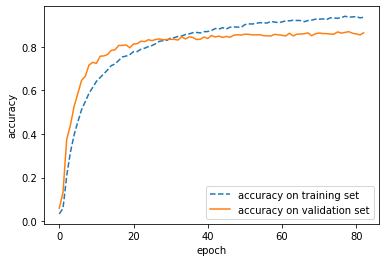

In [ ]:
print(history.history['accuracy'])

plt.plot(history.history['accuracy'],'--', label='accuracy on training set')
plt.plot(history.history['val_accuracy'], label='accuracy on validation set')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

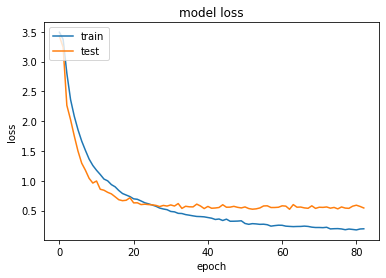

In [ ]:
# how the loss was changing
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

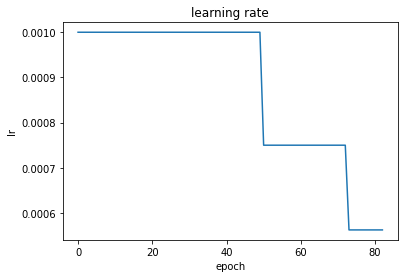

In [ ]:
# the change of the learning rate
plt.plot(history.history['lr'])
plt.title('learning rate')
plt.ylabel('lr')
plt.xlabel('epoch')
plt.show()

## <font color='purple'> 5. Evaluate on a test set

- Restore model from the checkpoint it was saved to.
- Create predictions for test images.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 25, 25, 128)       131200    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

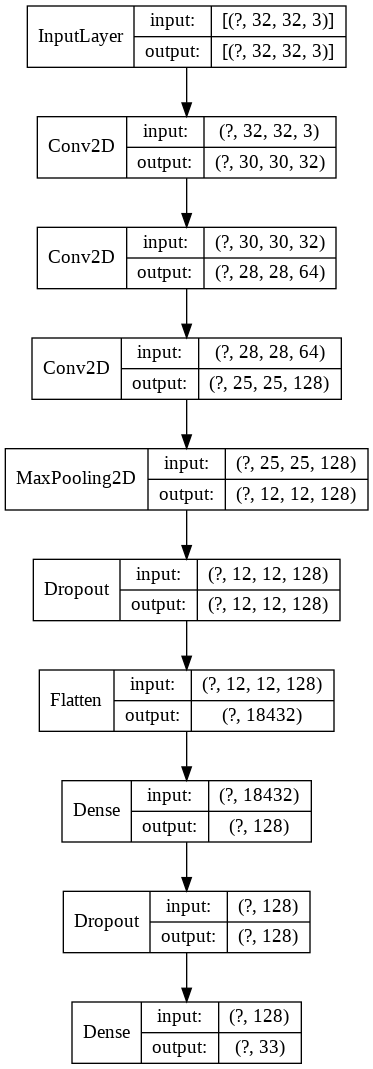

In [ ]:
cnn_model=models.load_model("/content/gdrive/My Drive/Letters/best_result_checkpoint",
                            custom_objects={'top_3_categorical_accuracy':top_3_categorical_accuracy}) 
cnn_model.summary()
plot_model(cnn_model, expand_nested=True, show_shapes=True, show_layer_names=False)

In [ ]:
loss, acc, top3_cat_acc = cnn_model.evaluate(X_val, y_val)
print("Loss", loss)
print("Accuracy", acc)
print("Top 3 categorical accuracy", top3_cat_acc)

89/89 [==============================] - 0s 3ms/step - loss: 0.5216 - accuracy: 0.8632 - top_3_categorical_accuracy: 0.9552
Loss 0.5215574502944946
Accuracy 0.8631876111030579
Top 3 categorical accuracy 0.9552186131477356


## <font color='scarlett'> 6. Visualize the model's predictions on test images

In [ ]:
# Define several helper functions.

def load_image(filename):
    img = load_img(filename, target_size=(32, 32))
    img = img_to_array(img)
    img = img.reshape(1, 32, 32, 3)
    img = img.astype('float32')
    img = img / 255.0
    return img

def get_true_target(filename, dataframe, column_to_get):
    filename = os.path.basename(os.path.normpath(filename))
    index_row = data[data['file']==filename].index[0]
    return data.loc[index_row, column_to_get]

def load_random_images(images_number = 9):
    """Load random images and their true labels.""""
    images = []
    true_targets = []

    which_folder = [random.randint(1,3) for _ in range(images_number)]
    for index_folder in which_folder:
        if index_folder == 1:
            path = folder +'letters/'
        else:
            path = folder +'letters'+str(index_folder)+'/'
        nb_files = len(os.listdir(path))

        index_image = random.randint(0, len(os.listdir(path)))

        image = load_image(path + os.listdir(path)[index_image])
        target = get_true_target(path + os.listdir(path)[index_image], data, 'letter')

        images.append(image)
        true_targets.append(target)

    return images, true_targets

def prediсt_classes(images_list_to_classify, true_labels, model):
    """Plot images with true and predicted labels."""
    plt.figure(figsize=(12,12))
    for index, image in enumerate(images_list_to_classify):
        pred = model.predict_classes(image)
        pred_letter = letters[pred[0]]

        plt.subplot(330 + 1 + index)
        plt.title('Predicted Label: %s \n'%pred_letter+\
                'True Label: %s\n'%true_labels[index],
                fontsize=18)

        plt.imshow(image[0])

    plt.subplots_adjust(bottom = 0.001)  # the bottom of the subplots of the figure
    plt.subplots_adjust(top = 0.99)

    # show the figure
    plt.show()

In [ ]:
test_images, test_targets = load_random_images()

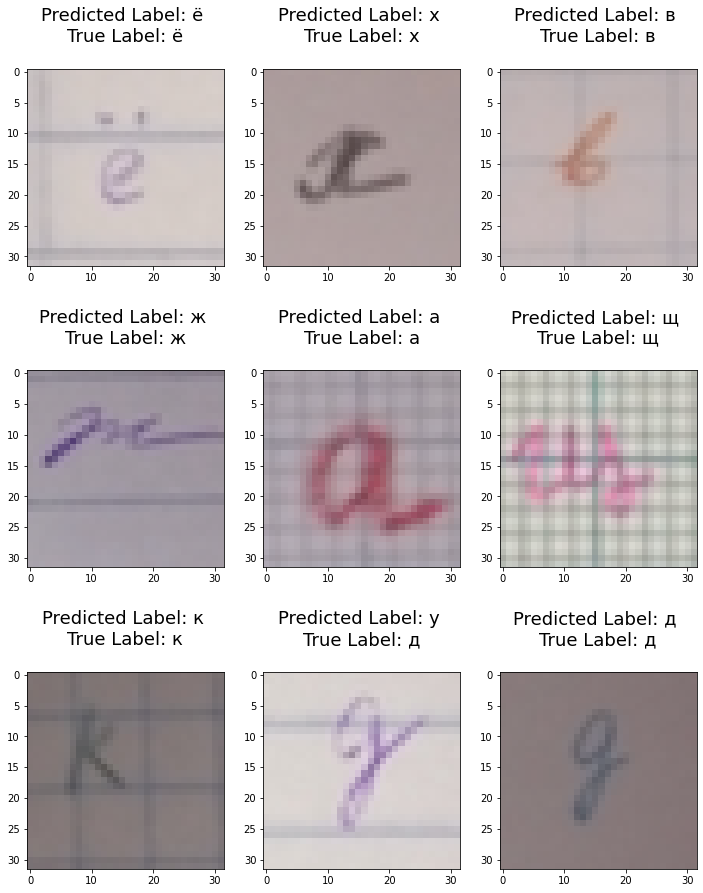

In [ ]:
prediсt_classes(test_images, test_targets, cnn_model)

## <font color='orange'> 7. Save the model to disk

When we are happy with the model's results, we can save the model to a file. We can also save weights and structure in different files.

In [ ]:
model_json = cnn_model.to_json()

with open(disk_folder+"/my_model" + ".json", "w") as f:
    f.write(model_json)

model.save_weights(disk_folder+"/my_model"+".h5")
print("The model is saved")

The model is saved
